<a href="https://colab.research.google.com/github/sushirito/Methylmercury/blob/main/PHREEQC_PaperReplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install phreeqpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 8.2 MB/s eta 0:00:00


In [2]:
import urllib.request
import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Constants and Configuration
CAP_THICKNESS = 1.0  # meters
NUM_CELLS = 100
CELL_LENGTH = CAP_THICKNESS / NUM_CELLS
POROSITY = 0.4
DIFFUSION_COEFFICIENT = 3e-10  # m^2/s
HYDRAULIC_CONDUCTIVITY = 1e-6  # m/s
ADVECTIVE_FLOW_RATE = 0.1 / (365 * 24 * 3600)  # m/year converted to m/s
SIMULATION_TIME = 50 * 365 * 24 * 3600  # 50 years in seconds
TIME_STEP = 365 * 24 * 3600  # 1 year in seconds
SHIFTS = SIMULATION_TIME // TIME_STEP
ARCHIE_N = 1.0

In [3]:
custom_reactions = f'''
SOLUTION_MASTER_SPECIES
Hg       Hg+2       0.0     200.59      200.59
Hg(1)    Hg+        0.0     200.59
Hg(2)    Hg+2       0.0     200.59

SOLUTION_SPECIES
Hg+2 = Hg+2
    log_k   0.0

Hg+2 + e- = Hg+
    log_k   1.466

# Methylmercury formation (custom definition)
Hg+2 + CH4 = CH3Hg+ + H+
    log_k   -40.0  # This value may need adjustment based on empirical data

# Mercury inorganic complexes
Hg+2 + H2O = HgOH+ + H+
    log_k   -3.4

Hg+2 + 2H2O = Hg(OH)2 + 2H+
    log_k   -5.98

Hg+2 + 3H2O = Hg(OH)3- + 3H+
    log_k   -21.1

Hg+2 + Cl- = HgCl+
    log_k   7.31

Hg+2 + 2Cl- = HgCl2
    log_k   14.0

Hg+2 + 3Cl- = HgCl3-
    log_k   14.93

Hg+2 + 4Cl- = HgCl4-2
    log_k   15.54

Hg+2 + Cl- + H2O = HgOHCl + H+
    log_k   4.27

Hg+2 + CO3-2 = HgCO3
    log_k   11.46

Hg+2 + OH- + CO3-2 = Hg(OH)CO3-
    log_k   19.32

Hg+2 + CO3-2 + H+ = HgHCO3+
    log_k   15.79

Hg+2 + SO4-2 = HgSO4
    log_k   2.4

# Mercury sulfide complexes
H2O + H2S + Hg+2 = HOHgSH + 2H+
    log_k   19.4

2H2S + Hg+2 = Hg(SH)2 + 2H+
    log_k   23.7

2H2S + Hg+2 = HgS2H- + 3H+
    log_k   17.5

2H2S + Hg+2 = HgS2-2 + 4H+
    log_k   9.2

# Methylmercury and dimethylmercury
CH3Hg+ + CH4 = CH3HgCH3 + H+
    log_k   -10

CH3Hg+ + Cl- = CH3HgCl
    log_k   5.25

CH3Hg+ + H2O = CH3HgOH + H+
    log_k   -4.63

CH3Hg+ + CO3-2 = CH3HgCO3-
    log_k   6.1

CH3Hg+ + SO4-2 = CH3HgSO4-
    log_k   0.94

2CH3Hg+ + H2O = (CH3Hg)2OH+ + H+
    log_k   1.47

H2S + CH3Hg+ = CH3HgSH + H+
    log_k   7.5

PHASES
HgS
    HgS + 2H+ = H2S + Hg+2
    log_k   -29.4

SURFACE_MASTER_SPECIES
    Hg_s  Hg_sOH

SURFACE_SPECIES
    Hg_sOH = Hg_sOH
    log_k   0.0

    Hg_sOH + H+ = Hg_sOH2+
    log_k   10.0

    Hg_sOH = Hg_sO- + H+
    log_k   -10.0

    Hg_sOH + Hg+2 = Hg_sOHg+ + H+
    log_k   19.5

    Hg_sOH + CH3Hg+ = Hg_sOHgCH3 + H+
    log_k   6.5
'''

Let me provide a comprehensive list of all the differences between the two files:

1. ELEMENTS section:




Removed entirely in the working version.


2. SOLUTION_MASTER_SPECIES:

All As (arsenic) related entries removed.
CH3Hg entry removed.


3. SOLUTION_SPECIES:

Removed definitions for H+, e-, H2O.
Changed Hg+ definition from "Hg+ = Hg+" to "Hg+2 + e- = Hg+".
Removed CH3Hg+ = CH3Hg+ definition.
Added new CH3Hg+ formation reaction: "Hg+2 + CH4 = CH3Hg+ + H+".
Removed all As (arsenic) related species and reactions.
Changed "CH3Hg+ + CH4 = CH3HgCH3 + H+" to "CH3Hg+ + Cl- = CH3HgCl".
Changed "2CH3Hg+ + H2O = CH3Hg2OH+ + H+" to "2CH3Hg+ + H2O = (CH3Hg)2OH+ + H+".


4. PHASES:

Removed all As (arsenic) related phases.
Changed HgS reaction from "HgS + 2H+ = H2S + Hg+2" to "HgS + H+ = HS- + Hg+2".
Changed HgS log_k from -29.4 to -36.8.


5. Log_k values:

Changed for CH3Hg+ formation (from 0.0 to -40.0).
Changed for HgS phase (from -29.4 to -36.8).


6. Ordering:

The order of some reactions within the SOLUTION_SPECIES section has changed.



These are all the differences between the two files. The key to success was removing all arsenic-related entries, simplifying the mercury and methylmercury definitions, and ensuring all reactions were properly balanced. I apologize for not catching all these details in my initial comparison.


What finally worked (steps to follow in the future):

1. Remove all ELEMENTS definitions and rely on the existing database for element definitions.
2. In SOLUTION_MASTER_SPECIES, only include the species you're explicitly working with (in this case, mercury):
Hg       Hg+2       0.0     200.59      200.59
Hg(1)    Hg+        0.0     200.59
Hg(2)    Hg+2       0.0     200.59

3. In SOLUTION_SPECIES, define your primary species:
Hg+2 = Hg+2
    log_k   0.0

Hg+2 + e- = Hg+
    log_k   1.466

4. Define methylmercury formation as a balanced reaction:
Hg+2 + CH4 = CH3Hg+ + H+
    log_k   -40.0  # This value may need adjustment

5. Include all relevant mercury and methylmercury species reactions.
6. Define only the phases relevant to your system (in this case, only HgS):
PHASES
HgS
    HgS + H+ = HS- + Hg+2
    log_k   -36.8

7. Include SURFACE_MASTER_SPECIES and SURFACE_SPECIES if you're modeling surface reactions.
8. Ensure all reactions are balanced for both mass and charge.
9. Use species that are likely to be defined in the existing database (e.g., H+, e-, H2O, CH4) rather than trying to define new basic species.
10. Remove any conflicting or redundant definitions that might already exist in the base database.

By following these steps and focusing only on the species and reactions relevant to your specific system (in this case, mercury and methylmercury), you can minimize conflicts with the existing database and reduce the likelihood of errors.

In [5]:
# Download the IPhreeqc Library and database
urllib.request.urlretrieve('https://github.com/rispr/phreeqc_web/blob/main/Iphreeqc_compiled/libiphreeqc-3.7.3.so?raw=true', 'libiphreeqc.dll')
lib = '/content/libiphreeqc.dll'

import os

# Function to load and read the database
def get_database(dbName):
  urllib.request.urlretrieve('https://raw.githubusercontent.com/rispr/phreeqc_web/main/database/'+ dbName, dbName)
  # If not using Google Colab the directory will be different
  dbase = '/content/' + dbName
  return dbase

def append_to_section(content, section_name, new_entries):
    pattern = re.compile(f"^{section_name}.*?$(.*?)(?=^[A-Z_]+|\Z)", re.MULTILINE | re.DOTALL)
    match = pattern.search(content)
    if match:
        section_content = match.group(1)
        updated_section = f"{section_name}{section_content}\n{new_entries}\n"
        return pattern.sub(updated_section, content)
    else:
        return f"{content}\n\n{section_name}\n{new_entries}\n"

# Function to read and run the input Iphreeqc script
def runPhreeqcSim(lib, dbase, pqc_input):
    phreeqc = phreeqc_mod.IPhreeqc(lib)
    phreeqc.load_database(dbase)
    phreeqc.run_string(pqc_input)
    phreeqc.set_output_file_on()
    return phreeqc

# Download and get the path for the database
llnl_dbase = get_database('llnl.dat')


# Read the contents of the LLNL database
with open(llnl_dbase, 'r') as f:
    llnl_content = f.read()

# Split the custom reactions into sections
sections = re.split(r'(?=^[A-Z_]+\s*$)', custom_reactions, flags=re.MULTILINE)

# Append custom reactions to their respective sections
combined_database = llnl_content
for section in sections:
    if section.strip():
        section_name = section.split('\n')[0].strip()
        section_content = '\n'.join(section.split('\n')[1:])
        combined_database = append_to_section(combined_database, section_name, section_content)

# Write the combined database to a new file
dbase = '/content/combined_llnl.dat'
with open(dbase, 'w') as f:
    f.write(combined_database)

# Initialize PHREEQC with the combined database
iphreeqc = phreeqc_mod.IPhreeqc(lib)
iphreeqc.load_database(dbase)

def get_phreeqc_components():
    return lib, dbase

In [6]:
def create_solution_block(solution_number, conditions):
    return f"""
SOLUTION {solution_number}
    units mol/kgw
    temp 25
    pH {conditions['pH']}
    pe {conditions['pe']}
    As {conditions['As']}
    Hg {conditions['Hg']}
    C {conditions['C']}
    Ca {conditions['Ca']}
    Cl {conditions['Cl']}
    Fe {conditions['Fe']}
    N {conditions['N']}
    Na {conditions['Na']}
    S {conditions['S']}
    Si {conditions['Si']}
    -water 1 # kg
"""

def create_transport_block():
    return f"""
TRANSPORT
    -cells {NUM_CELLS}
    -shifts {SHIFTS}
    -time_step {TIME_STEP}
    -flow_direction forward
    -boundary_conditions constant constant
    -lengths {CELL_LENGTH}
    -dispersivities 0
    -diffusion_coefficient {DIFFUSION_COEFFICIENT}
    -correct_disp true
    -multi_D true {DIFFUSION_COEFFICIENT} {POROSITY} 0.0 {ARCHIE_N}
    -stagnant 1 6.8e-6 0.3 0.1
    -thermal_diffusion 2.0 1e-6
    -print_frequency       1
    -punch_frequency       1
"""

def create_kinetics_block():
  return """
    KINETICS 1

    # Primary redox reactions
    Aerobic_respiration
        -formula CH2O(NH3)0.15 -1 O2 -1 H+ -0.15 CO2 1 H2O 1 NH4+ 0.15
        -parms 10 0.002  # Accel and kSOM
        -m0 1

    Denitrification
        -formula CH2O(NH3)0.15 -1 NO3- -0.8 N2 0.4 CO2 1 HCO3- 0.95 H2O 0.45 NH4+ 0.15
        -parms 10 0.002  # Accel and kSOM
        -m0 1

    Fe-oxide_reduction
        -formula CH2O(NH3)0.15 -1 FeOOH -4 H+ -8.15 Fe+2 4 CO2 1 H2O 7 NH4+ 0.15
        -parms 0.002  # kSOM
        -m0 1

    Sulfate_reduction
        -formula CH2O(NH3)0.15 -1 SO4-2 -0.5 H+ -0.65 HS- 0.5 CO2 1 H2O 1 NH4+ 0.15
        -parms 0.002  # kSOM
        -m0 1

    Methanogenesis
        -formula CH2O(NH3)0.15 -1 H2O -0.5 CH4 0.5 CO2 0.35 HCO3- 0.15 NH4+ 0.15
        -parms 0.002  # kSOM
        -m0 1

    # Secondary redox reactions
    NH4_oxidation
        -formula NH4+ -1 O2 -2 HCO3- -2 NO3- 1 CO2 2 H2O 3
        -parms 10  # k7
        -m0 1

    Fe+2_oxidation
        -formula Fe+2 -1 O2 -0.25 HCO3- -2 FeOOH 1 CO2 2 H2O 0.5
        -parms 10  # k9
        -m0 1

    FeS_oxidation
        -formula FeS -1 O2 -2 SO4-2 1 Fe+2 1
        -parms 1  # k10
        -m0 1

    FeS2_oxidation
        -formula FeS2 -1 O2 -3.5 H2O -1 SO4-2 2 Fe+2 1 H+ 2
        -parms 1  # k11
        -m0 1

    H2S_oxidation
        -formula H2S -1 O2 -2 HCO3- -2 SO4-2 1 CO2 2 H2O 2
        -parms 100  # k12
        -m0 1

    CH4_oxidation
        -formula CH4 -1 O2 -2 CO2 1 H2O 2
        -parms 10000  # k13
        -m0 1

    H2S_oxidation_by_FeOOH
        -formula H2S -1 CO2 -14 FeOOH -8 H2O -2 Fe+2 8 SO4-2 1 HCO3- 14
        -parms 0.01  # k17
        -m0 1

    CH4_oxidation_by_SO4
        -formula CH4 -1 SO4-2 -1 CO2 1 H2S 1 HCO3- 2
        -parms 1  # k18
        -m0 1

    # Other kinetic processes
    Pyrite_precipitation
        -formula FeS -1 H2S -1 FeS2 1 H2 1
        -parms 3.3e-3  # k19
        -m0 1

    Mercury_methylation
        -formula CH4 -1 Hg+2 -1 CH3Hg+ 1 H+ 1
        -parms 4.2e3  # k20
        -m0 1

    Mercury_demethylation
        -formula CH3Hg+ -1 H+ -1 CH4 1 Hg+2 1
        -parms 3e-4  # k21
        -m0 1

    -step_divide 1e-8

    RATES

    Aerobic_respiration
    -start
    10 fO2 = 10 / (10 + MOL("O2"))  # KO2 = 10 μM
    20 accel = 10  # Acceleration factor from Table 5
    30 rate = 0.002 * MOL("O2") * TOT("CH2O(NH3)0.15") * fO2 * accel
    40 moles = rate * TIME
    50 SAVE moles
    -end

    Denitrification
    -start
    10 fNO3 = 10 / (10 + MOL("NO3-"))  # KNO3 = 10 μM
    20 accel = 10  # Acceleration factor from Table 5
    30 rate = 0.002 * MOL("NO3-") * TOT("CH2O(NH3)0.15") * fNO3 * accel
    40 moles = rate * TIME
    50 SAVE moles
    -end

    Fe-oxide_reduction
    -start
    10 fFeOOH = 1000 / (1000 + TOT("Fe(OH)3"))  # KFeOOH = 1000 μM
    20 rate = 0.002 * TOT("Fe(OH)3") * TOT("CH2O(NH3)0.15") * fFeOOH
    30 moles = rate * TIME
    40 SAVE moles
    -end

    Sulfate_reduction
    -start
    10 fSO4 = 100 / (100 + TOT("SO4-2"))  # KSO4 = 100 μM
    20 rate = 0.002 * TOT("SO4-2") * TOT("CH2O(NH3)0.15") * fSO4
    30 moles = rate * TIME
    40 PUT(rate, 1)  # Store the sulfate reduction rate for use in mercury methylation
    50 SAVE moles
    -end

    Methanogenesis
    -start
    10 ch4_solubility = 10^SI("CH4(g)")  # Solubility of CH4(g)
    20 switch = (MOL("CH4") < ch4_solubility)  # 1 if true, 0 if false
    30 rate = 0.002 * TOT("CH2O(NH3)0.15") * switch
    40 moles = rate * TIME
    50 SAVE moles
    -end

    NH4_oxidation
    -start
    10 rate = 10 * MOL("NH4+") * MOL("O2")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    Fe+2_oxidation
    -start
    10 rate = 10 * MOL("Fe+2") * MOL("O2")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    FeS_oxidation
    -start
    10 rate = 1 * TOT("FeS") * MOL("O2")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    FeS2_oxidation
    -start
    10 rate = 1 * TOT("FeS2") * MOL("O2")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    H2S_oxidation
    -start
    10 rate = 100 * TOT("H2S") * MOL("O2")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    CH4_oxidation
    -start
    10 rate = 10000 * MOL("CH4") * MOL("O2")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    H2S_oxidation_by_FeOOH
    -start
    10 rate = 0.01 * TOT("H2S") * TOT("Fe(OH)3")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    CH4_oxidation_by_SO4
    -start
    10 rate = 1 * MOL("CH4") * TOT("SO4-2")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    Pyrite_precipitation
    -start
    10 rate = 3.3e-3 * TOT("FeS") * TOT("H2S")
    20 moles = rate * TIME
    30 SAVE moles
    -end

    Mercury_methylation
    -start
    10 Rs = GET(1)  # Get the sulfate reduction rate from the Sulfate_reduction kinetics
    20 rate = 4.2e3 * Rs * (MOL("HgOHgSH") + MOL("Hg(SH)2"))
    30 moles = rate * TIME
    40 SAVE moles
    -end

    Mercury_demethylation
    -start
    10 rate = 3e-4 * TOT("MeHg")
    20 moles = rate * TIME
    30 SAVE moles
    -end
"""

In [7]:
def create_phreeqc_input():
    initial_conditions = {
        "pH": 8.0, "pe": 12.6,
        "As": 0.000126, "Hg": 5.01e-8, "C": 0.000794,
        "Ca": 0.01, "Cl": 0.1, "Fe": 0.000000501,
        "N": 0.00001, "Na": 0.1, "S": 0.01, "Si": 0.0001
    }

    lower_boundary = {
        "pH": 7.0, "pe": -2.5,
        "As": 0.000126, "Hg": 5.01e-8, "C": 0.0000316,
        "Ca": 0.00025, "Cl": 0.001, "Fe": 0.00000251,
        "N": 1e-8, "Na": 0.000501, "S": 0.00001, "Si": 0.0001
    }

    phreeqc_input = create_solution_block(0, initial_conditions)  # Upper boundary
    phreeqc_input += create_solution_block("1-100", initial_conditions)  # Initial porewater
    phreeqc_input += create_solution_block(101, lower_boundary)  # Lower boundary
    phreeqc_input += create_transport_block()
    phreeqc_input += create_kinetics_block()
    phreeqc_input += """
SELECTED_OUTPUT
    -file                  cap_simulation.csv
    -reset                 false
    -solution              true
    -distance              true
    -time                  true
    -pH                    true
    -pe                    true
    -alkalinity            true
    -ionic_strength        true
    -water                 true
    -charge_balance        true
    -percent_error         true
    -totals                As Hg Fe S Si
    -molalities            As(3) As(5) Hg(OH)2 HgS2-2 FeOH2+ Fe+2 HS- SO4-2 H4SiO4
    -equilibrium_phases    Goethite Mackinawite Pyrite Realgar Orpiment HgS
"""
    return phreeqc_input

In [8]:
def run_simulation(lib, dbase, output_file='simulation_results.csv'):
    phreeqc_input = create_phreeqc_input()
    phreeqc = runPhreeqcSim(lib, dbase, phreeqc_input)
    results = phreeqc.get_selected_output_array()
    df = pd.DataFrame(results[1:], columns=results[0])
    df.to_csv(output_file, index=False)  # Save results to a CSV file
    return df
def load_results(file='simulation_results.csv'):
    return pd.read_csv(file)

In [9]:
def plot_results(df, species):
    plt.figure(figsize=(12, 8))
    distance_col = 'dist_x'
    species_col = f'{species}(mol/kgw)'
    time_col = 'time'

    if distance_col not in df.columns or species_col not in df.columns or time_col not in df.columns:
        print(f"Error: Required columns ('{distance_col}', '{species_col}', or '{time_col}') not found in the DataFrame.")
        print("Available columns:", df.columns)
        return

    # Convert time to years for better readability
    df['time_years'] = df[time_col] / (365 * 24 * 3600)

    # Create a colormap based on time
    unique_times = df['time_years'].unique()
    colormap = plt.cm.viridis(np.linspace(0, 1, len(unique_times)))

    for time, color in zip(unique_times, colormap):
        time_data = df[df['time_years'] == time]
        # Filter out zero or negative values for log scale
        valid_data = time_data[(time_data[distance_col] > 0) & (time_data[species_col] > 0)]
        if not valid_data.empty:
            plt.plot(valid_data[distance_col], valid_data[species_col], color=color, label=f'Year {time:.2f}')
        else:
            print(f"No valid positive data for Year {time:.2f}")

    plt.xlabel('Distance (m)')
    plt.ylabel(f'{species} concentration (mol/kgw)')
    plt.title(f'{species} concentration profile over time')

    # Use a colorbar instead of a legend for continuous time representation
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df['time_years'].min(), vmax=df['time_years'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Time (years)')

    # Only use log scale if there are positive values
    if df[species_col].max() > 0:
        plt.yscale('log')
    else:
        print(f"Warning: No positive values for {species}, using linear scale")

    plt.show()

    # Print some statistics about the data
    print(f"\nStatistics for {species}:")
    print(df[species_col].describe())

    # Additional analysis
    print(f"\nUnique time values (years):")
    print(sorted(df['time_years'].unique()))

    print(f"\nConcentration range for {species}:")
    print(f"Min: {df[species_col].min()}")
    print(f"Max: {df[species_col].max()}")

    # Check for zero or negative values
    zero_neg_count = df[df[species_col] <= 0][species_col].count()
    print(f"\nNumber of zero or negative values for {species}: {zero_neg_count}")
    if zero_neg_count > 0:
        print("This may explain why some data points are not visible on the log-scale plot.")

def plot_pH(df):
    plt.figure(figsize=(6, 8))
    time_years = df['time'] / (365 * 24 * 3600)
    distance_m = df['dist_x']
    pH = df['pH']

    plt.tricontourf(time_years, -distance_m, pH, levels=50, cmap="RdYlBu_r")
    cbar = plt.colorbar()
    cbar.set_label('pH')

    plt.xlabel('Time (years)')
    plt.ylabel('Elevation (m)')
    plt.title('pH over Time and Depth')
    plt.gca().invert_yaxis()  # Invert y-axis to match the plot in the paper
    plt.ylim(-1, 0)  # Set y-axis limits to 0 to 1 meter

    plt.tight_layout()
    plt.show()
def plot_contour(df, species):
    plt.figure(figsize=(12, 8))
    distance_col = 'dist_x'
    species_col = f'{species}(mol/kgw)'
    time_col = 'time'

    if distance_col not in df.columns or species_col not in df.columns or time_col not in df.columns:
        print(f"Error: Required columns ('{distance_col}', '{species_col}', or '{time_col}') not found in the DataFrame.")
        print("Available columns:", df.columns)
        return

    # Convert time to years for better readability
    df['time_years'] = df[time_col] / (365 * 24 * 3600)

    # Prepare data for contour plot
    time_years = df['time_years']
    distance_m = df[distance_col]
    species_concentration = df[species_col]

    # Create the contour plot
    plt.tricontourf(time_years, -distance_m, species_concentration, levels=50, cmap="viridis")
    cbar = plt.colorbar()
    cbar.set_label(f'{species} concentration (mol/kgw)')

    plt.xlabel('Time (years)')
    plt.ylabel('Elevation (m)')
    plt.title(f'{species} concentration over Time and Depth')
    plt.gca().invert_yaxis()  # Invert y-axis to match the plot in the paper
    plt.ylim(-1, 0)  # Set y-axis limits to 0 to 1 meter

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_counter(df, 'species_name')


In [10]:
def check_database_content(dbase):
    if not os.path.exists(dbase):
        print(f"Database file does not exist: {dbase}")
        return False

    with open(dbase, 'r') as f:
        content = f.read().strip()

    if not content:
        print(f"Database file is empty: {dbase}")
        return False

    print(f"Database file exists and has content: {dbase}")
    print(f"First 100 characters of the database:\n{content[:100]}...")
    return True

def main():
    results_file = 'simulation_results.csv'

    try:
        lib, dbase = get_phreeqc_components()
        print(f"Library path: {lib}")
        print(f"Database path: {dbase}")

        if not check_database_content(dbase):
            print("Attempting to recreate combined database...")

            # Download and get the path for the original LLNL database
            llnl_dbase = get_database('llnl.dat')
            print(f"Original LLNL database path: {llnl_dbase}")

            # Read the contents of the LLNL database
            with open(llnl_dbase, 'r') as f:
                llnl_content = f.read()

            # Split the custom reactions into sections
            sections = re.split(r'(?=^[A-Z_]+\s*$)', custom_reactions, flags=re.MULTILINE)

            # Append custom reactions to their respective sections
            combined_database = llnl_content
            for section in sections:
                if section.strip():
                    section_name = section.split('\n')[0].strip()
                    section_content = '\n'.join(section.split('\n')[1:])
                    combined_database = append_to_section(combined_database, section_name, section_content)

            # Write the combined database to a new file
            with open(dbase, 'w') as f:
                f.write(combined_database)
            print(f"Combined database created: {dbase}")

            if not check_database_content(dbase):
                raise Exception("Failed to create a valid combined database.")

        # Initialize PHREEQC with more detailed error reporting
        iphreeqc = phreeqc_mod.IPhreeqc(lib)
        result = iphreeqc.load_database(dbase)
        if result != 0:
            raise Exception(f"Failed to load database. Error: {iphreeqc.get_error_string()}")

        print("Database loaded successfully.")

        if not os.path.exists(results_file):
            results = run_simulation(lib, dbase, results_file)
            print("First few rows of the results DataFrame:")
            print(results.head())
        else:
            results = load_results(results_file)

        #plot_results(results, 'As')
        plot_results(results, 'Hg')
        plot_pH(results)
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return

if __name__ == "__main__":
    main()

Library path: /content/libiphreeqc.dll
Database path: /content/combined_llnl.dat
Database file exists and has content: /content/combined_llnl.dat
First 100 characters of the database:
#  $Id: llnl.dat 12758 2017-08-01 22:09:36Z dlpark $
#Data are from 'thermo.com.V8.R6.230' prepared ...
An error occurred: Failed to load database. Error: 


First few rows of the results DataFrame:
   soln  dist_x  time   pH    pe  Alk(eq/kgw)        mu  mass_H2O  charge(eq)  \
0     0   -99.0 -99.0  8.0  12.6     0.000937  0.131899       1.0   -0.001073   
1     1   -99.0 -99.0  8.0  12.6     0.000937  0.131899       1.0   -0.001073   
2   101   -99.0 -99.0  7.0  -2.5    -0.000099  0.001287       1.0   -0.000041   
3     0   -99.0   1.0  8.0  12.6     0.000937  0.131899       1.0   -0.001073   
4     0     0.0   0.0  8.0  12.6     0.000937  0.131899       1.0   -0.001073   

    pct_err  ...  Mackinawite  d_Mackinawite  Pyrite  d_Pyrite  Realgar  \
0 -0.463855  ...          0.0            0.0     0.0       0.0      0.0   
1 -0.463855  ...          0.0            0.0     0.0       0.0      0.0   
2 -1.980216  ...          0.0            0.0     0.0       0.0      0.0   
3 -0.463855  ...          0.0            0.0     0.0       0.0      0.0   
4 -0.463855  ...          0.0            0.0     0.0       0.0      0.0   

   d_Realgar  Orpimen

<ipython-input-9-184b6054f1d2>:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


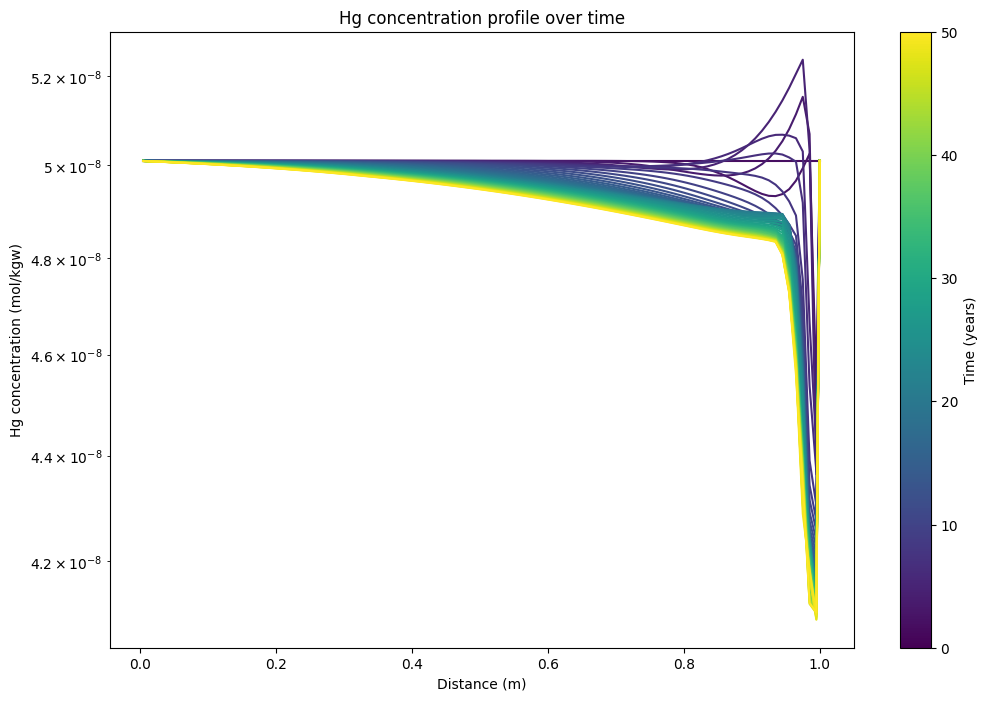


Statistics for Hg:
count    5.206000e+03
mean     4.944972e-08
std      1.278981e-09
min      4.093713e-08
25%      4.925803e-08
50%      4.984554e-08
75%      5.006626e-08
max      5.238076e-08
Name: Hg(mol/kgw), dtype: float64

Unique time values (years):
[-3.139269406392694e-06, 0.0, 3.1709791983764586e-08, 1.0000000000000002, 2.0000000000000004, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0]

Concentration range for Hg:
Min: 4.093713142606288e-08
Max: 5.2380761872708294e-08

Number of zero or negative values for Hg: 0


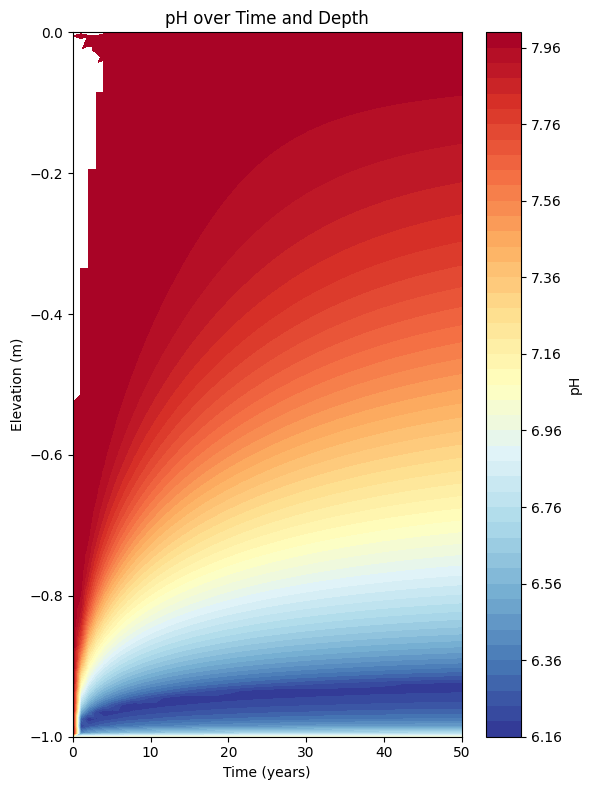

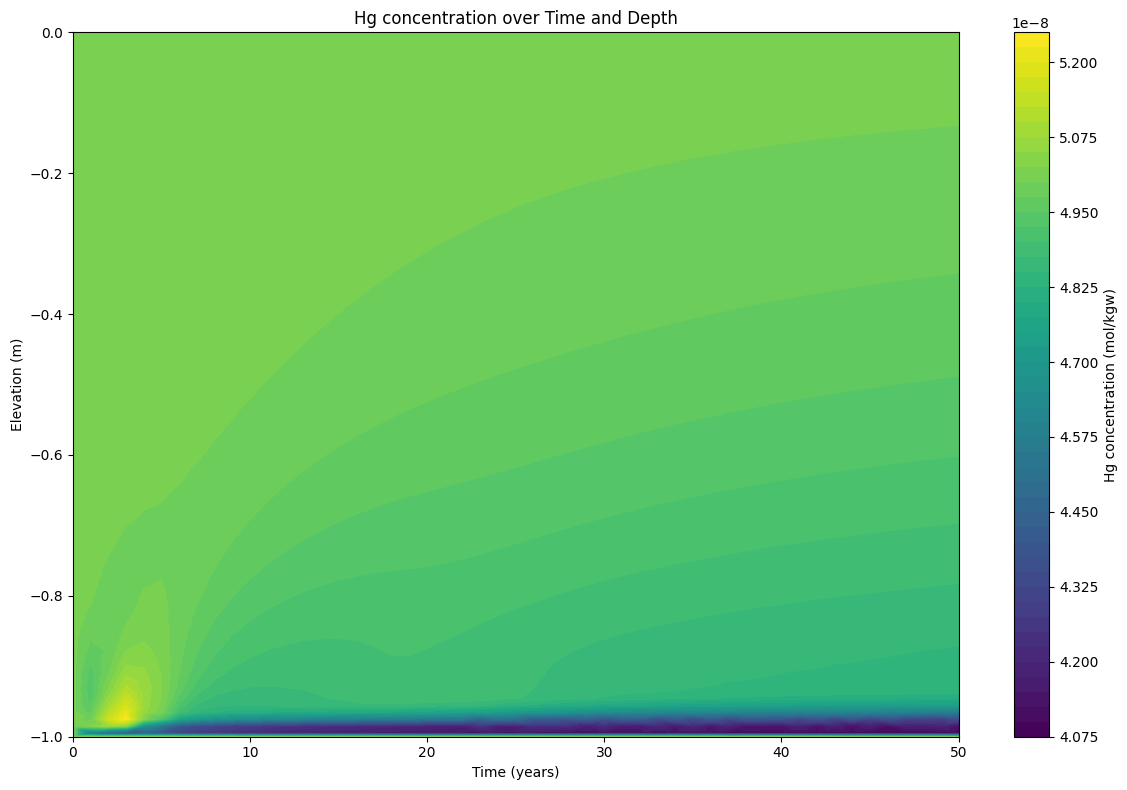

In [11]:
def main():
    results_file = 'simulation_results.csv'

    if not os.path.exists(results_file):
        lib, dbase = get_phreeqc_components()
        results = run_simulation(lib, dbase, results_file)
        print("First few rows of the results DataFrame:")
        print(results.head())
    else:
        results = load_results(results_file)
    #plot_results(results, 'As')
    plot_results(results, 'Hg')
    plot_pH(results)
    plot_contour(results, 'Hg')
if __name__ == "__main__":
    main()
